In [4]:
# Standart Veri Manipülasyon ve Görselleştirme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

# Model Hazırlık ve Ön İşleme
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Algoritmalar (Üretim odaklı ana modelimiz)
from sklearn.ensemble import RandomForestClassifier

# Metrikler (İş birimleri için raporlama standartları)
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    roc_curve
)

# Görselleştirme Ayarları (Trendyol Tech Raporlama Standartları için)
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Uyarıları sessize al
import warnings
warnings.filterwarnings('ignore')

print(f"✅ Gerekli kütüphaneler yüklendi. İşlem Zamanı: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Gerekli kütüphaneler yüklendi. İşlem Zamanı: 2025-12-19 00:15:05


In [5]:
def generate_fraud_data(n_rows=2000, fraud_ratio=0.10):
    """
    Trendyol standartlarında sentetik fraud veri seti üretir ve temel kontrolleri yapar.
    """
    np.random.seed(42)
    
    # 1. Temel Yapı
    data = {
        'Transaction ID': range(10000, 10000 + n_rows),
        'Customer ID': np.random.randint(100, 200, n_rows),
        'Amount (TRY)': np.random.uniform(50, 2000, n_rows),
        'Timestamp': pd.to_datetime('2023-01-01') + pd.to_timedelta(np.random.randint(0, 30*24*60, n_rows), unit='m'),
        'Payment Type': np.random.choice(['Credit Card', 'Debit Card', 'Bank Transfer'], n_rows),
        'Shipping Type': np.random.choice(['Standard', 'Express', 'Pick-up'], n_rows),
        'Card Type (BIN)': np.random.choice(['Visa', 'MasterCard', 'Amex'], n_rows),
        'Shipping City': np.random.choice(['Istanbul', 'Ankara', 'Izmir', 'Bursa', 'Antalya'], n_rows),
        'IS_FRAUD (Target)': 0
    }
    df = pd.DataFrame(data)

    # 2. Fraud Senaryoları Enjeksiyonu
    fraud_count = int(n_rows * fraud_ratio)
    fraud_indices = np.random.choice(df.index, size=fraud_count, replace=False)
    df.loc[fraud_indices, 'IS_FRAUD (Target)'] = 1

    # Senaryo A: Yüksek Tutar (Outlier)
    df.loc[df['IS_FRAUD (Target)'] == 1, 'Amount (TRY)'] *= np.random.uniform(3, 7)

    # Senaryo B: Şüpheli Saat Dilimi (Gece 02:00 - 05:00)
    df.loc[df['IS_FRAUD (Target)'] == 1, 'Timestamp'] = \
        df.loc[df['IS_FRAUD (Target)'] == 1, 'Timestamp'].apply(lambda x: x.replace(hour=np.random.randint(2, 6)))

    # 3. Trendyol Tech Sanity Checks (Veri Doğrulama)
    print("--- Veri Doğrulama Raporu ---")
    print(f"✅ Toplam İşlem: {len(df)}")
    print(f"✅ Fraud Oranı: %{(df['IS_FRAUD (Target)'].sum() / len(df)) * 100:.1f}")
    print(f"✅ Eksik Veri (Null): {df.isnull().sum().sum()}")
    
    # Veriyi kaydet
    df.to_csv('REALISTIC_FRAUD_DATA.csv', index=False)
    return df

# Veriyi oluştur ve değişkene ata
df = generate_fraud_data(n_rows=2000)
print("\n🚀 Veri seti hazır ve 'df' değişkenine yüklendi.")

--- Veri Doğrulama Raporu ---
✅ Toplam İşlem: 2000
✅ Fraud Oranı: %10.0
✅ Eksik Veri (Null): 0

🚀 Veri seti hazır ve 'df' değişkenine yüklendi.


✅ Özellikler türetildi. Yeni sütunlar: ['Amount (TRY)', 'Payment Type', 'Shipping Type', 'Card Type (BIN)', 'Shipping City', 'IS_FRAUD (Target)', 'Customer_Freq', 'Customer_Avg_Amount', 'Amount_Diff', 'Hour', 'DayOfWeek']


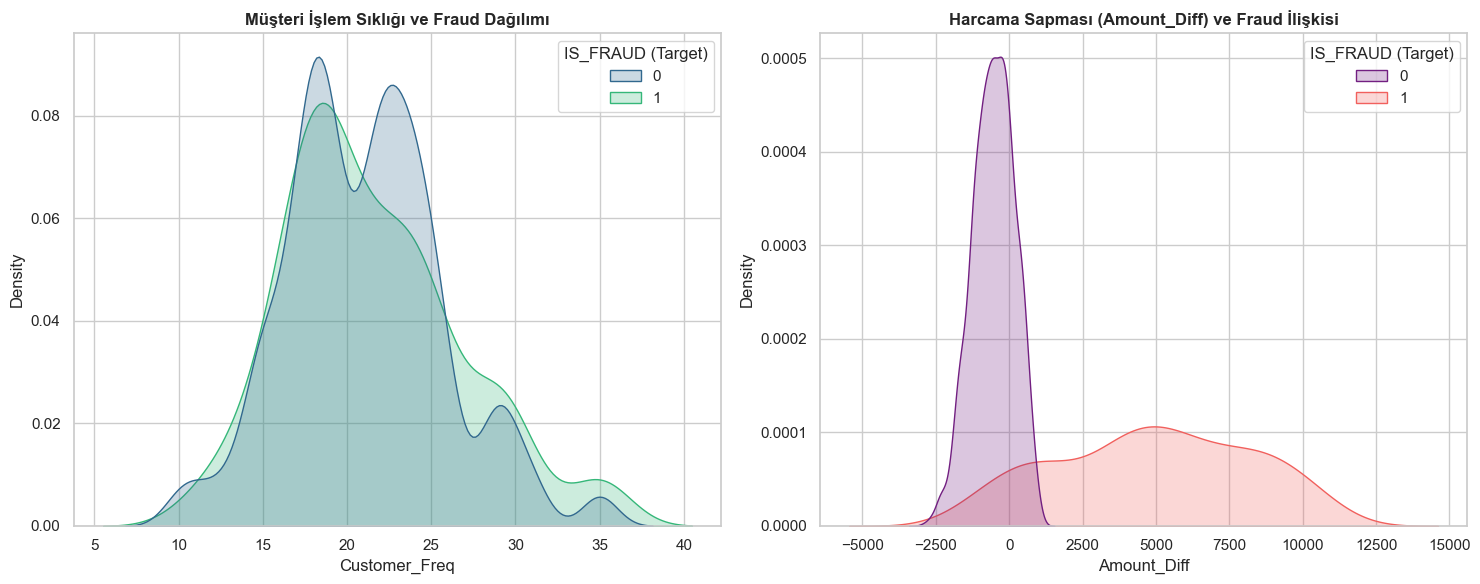

In [7]:
def apply_feature_engineering(data):
    """
    Trendyol standartlarında özellik mühendisliği hattı.
    Aynı mantık hem eğitim hem de canlı tahmin (API) sırasında kullanılır.
    """
    df_processed = data.copy()

    # 1. Davranışsal Özellikler
    # Not: Gerçek sistemde bu veriler 'Feature Store'dan (Redis vb.) hazır gelir.
    df_processed['Customer_Freq'] = df_processed.groupby('Customer ID')['Transaction ID'].transform('count')
    df_processed['Customer_Avg_Amount'] = df_processed.groupby('Customer ID')['Amount (TRY)'].transform('mean')
    df_processed['Amount_Diff'] = df_processed['Amount (TRY)'] - df_processed['Customer_Avg_Amount']

    # 2. Zaman Özellikleri (Temporal Features)
    df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'])
    df_processed['Hour'] = df_processed['Timestamp'].dt.hour
    df_processed['DayOfWeek'] = df_processed['Timestamp'].dt.dayofweek

    # 3. Model İçin Temizlik
    # 'IS_FRAUD (Target)' sütununu koruyarak gereksizleri atıyoruz
    cols_to_drop = ['Transaction ID', 'Customer ID', 'Timestamp']
    df_processed = df_processed.drop(columns=[c for c in cols_to_drop if c in df_processed.columns])

    return df_processed

# Özellikleri türet
df_clean = apply_feature_engineering(df)
print(f"✅ Özellikler türetildi. Yeni sütunlar: {df_clean.columns.tolist()}")

# 4. Gelişmiş Görselleştirme (Trendyol Dashboard Standartları)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Frekans Analizi
# common_norm=False: Fraud azınlıkta olsa bile dağılımını net görmemizi sağlar.
sns.kdeplot(data=df_clean, x='Customer_Freq', hue='IS_FRAUD (Target)', 
            fill=True, ax=axes[0], common_norm=False, palette='viridis')
axes[0].set_title('Müşteri İşlem Sıklığı ve Fraud Dağılımı', fontsize=12, fontweight='bold')

# 2. Harcama Sapması Analizi
sns.kdeplot(data=df_clean, x='Amount_Diff', hue='IS_FRAUD (Target)', 
            fill=True, ax=axes[1], common_norm=False, palette='magma')
axes[1].set_title('Harcama Sapması (Amount_Diff) ve Fraud İlişkisi', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
# 4. HÜCRE: KATEGORİK DEĞİŞKEN DÖNÜŞTÜRME (ENCODING)

# Kategorik (metin) sütunları otomatik bulalım
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
encoders = {}

# Her sütun için ayrı bir Encoder eğitip saklıyoruz (Production standardı)
for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    encoders[col] = le # API aşamasında kullanmak üzere sözlükte saklıyoruz

print(f"✅ Kategorik sütunlar başarıyla dönüştürüldü: {categorical_cols}")
print("📊 Verinin ilk 5 satırı (Tamamen Sayısal):")
display(df_clean.head())

✅ Kategorik sütunlar başarıyla dönüştürüldü: ['Payment Type', 'Shipping Type', 'Card Type (BIN)', 'Shipping City']
📊 Verinin ilk 5 satırı (Tamamen Sayısal):


,Amount (TRY),Payment Type,Shipping Type,Card Type (BIN),Shipping City,IS_FRAUD (Target),Customer_Freq,Customer_Avg_Amount,Amount_Diff,Hour,DayOfWeek
0,250.445189,2,1,0,0,0,18,926.324112,-675.878923,18,3
1,1163.263779,1,2,0,1,0,24,1548.581429,-385.317650,10,6
2,85.816892,0,0,1,4,0,22,1322.895721,-1237.078829,0,3
3,990.594944,0,2,0,2,0,21,1252.130031,-261.535087,16,3
4,460.181681,2,2,2,3,0,18,832.089315,-371.907634,9,3



🎯 TRENDYOL TECH - FRAUD MODEL RAPORU
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       360
           1       1.00      0.90      0.95        40

    accuracy                           0.99       400
   macro avg       0.99      0.95      0.97       400
weighted avg       0.99      0.99      0.99       400



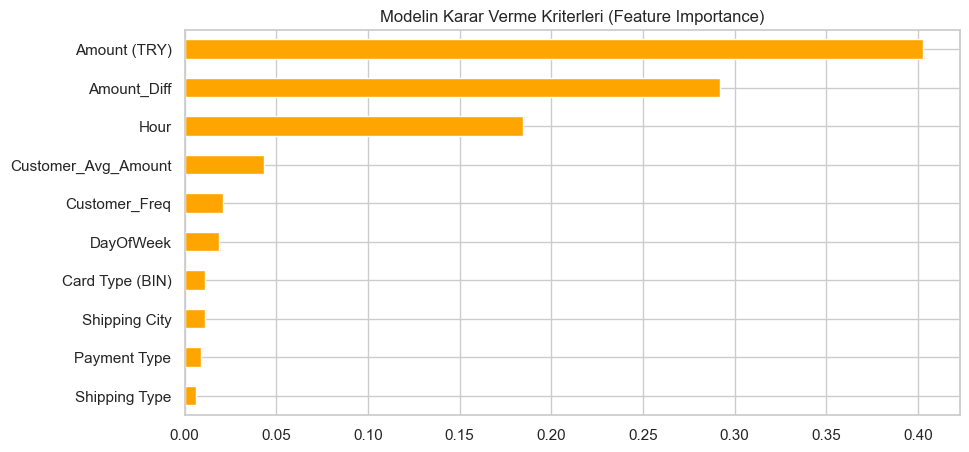


✅ Model ('final_fraud_model.pkl') ve Encoderlar ('encoders_dict.pkl') başarıyla kaydedildi.
🚀 Proje başarıyla tamamlandı! Artık canlı sistem entegrasyonuna hazır.


In [10]:
# 5. HÜCRE: MODEL EĞİTİMİ VE FİNAL

# 1. Veriyi Bölme (X ve y)
X = df_clean.drop(columns=['IS_FRAUD (Target)'])
y = df_clean['IS_FRAUD (Target)']

# Stratify=y: Eğitim ve test setindeki fraud oranının eşit olmasını sağlar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# 2. Model Eğitimi (Dengeli Sınıf Ağırlığı ile)
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 3. Performans Raporu
y_pred = model.predict(X_test)
print("\n" + "="*40)
print("🎯 TRENDYOL TECH - FRAUD MODEL RAPORU")
print("="*40)
print(classification_report(y_test, y_pred))

# 4. Özellik Önemi (Feature Importance)
plt.figure(figsize=(10, 5))
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
importances.plot(kind='barh', color='orange')
plt.title('Modelin Karar Verme Kriterleri (Feature Importance)')
plt.show()

# 5. ÜRETİM İÇİN KAYDETME (Persistence) - KRİTİK DÜZELTME BURADA 👇
import joblib
joblib.dump(model, 'final_fraud_model.pkl')

# 4. hücrede oluşturduğumuz 'encoders' sözlüğünü de mutlaka kaydediyoruz!
joblib.dump(encoders, 'encoders_dict.pkl') 

print("\n✅ Model ('final_fraud_model.pkl') ve Encoderlar ('encoders_dict.pkl') başarıyla kaydedildi.")
print("🚀 Proje başarıyla tamamlandı! Artık canlı sistem entegrasyonuna hazır.")